Import required libraries

In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, Polygon, MultiPolygon
import matplotlib.pyplot as plt
from shapely.ops import cascaded_union
import numpy as np
from fiona.crs import from_epsg
from sklearn.linear_model import LogisticRegression
import rpy2.robjects as ro
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import r, pandas2ri
from rpy2.robjects import Formula
pandas2ri.activate()
from sklearn import metrics
import seaborn as sns
import rasterio
import glob
from pyproj import CRS
from fiona.crs import from_epsg


E:\spatial\lib\site-packages\rpy2\robjects\pandas2ri.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [2]:
ro.r('install.packages("dismo", dependencies=TRUE)')
ro.r('install.packages("raster", dependencies=TRUE)')
ro.r('install.packages("shapefiles", dependencies=TRUE)')
ro.r('install.packages("rgdal", dependencies=TRUE)')
ro.r('install.packages("ggplot2", dependencies=TRUE)')
ro.r('install.packages("gamsel", dependencies=TRUE)')
ro.r('install.packages("foreign", dependencies=TRUE)')

In [4]:
shapefiles = importr("shapefiles")
dismo = importr("dismo")
rgdal = importr("rgdal")
raster = importr("raster")
base = importr("base")
utils = importr("utils")
ggplot2 = importr("ggplot2")
gamsel = importr("gamsel")

In [4]:
ro.r('library(dismo)')
ro.r('library(raster)')
ro.r('library(shapefiles)')
#ro.r('library(sf)')

'gamsel','mda','class','foreach',...,'utils','datasets','methods','base'


E:\spatial\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<AxesSubplot:>

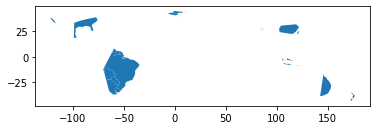

In [5]:
alty_mcp_polygons=gpd.read_file('alty_mcp_polygon.shp')
alty_mcp_polygons.crs=from_epsg(4326)
alty_mcp_polygons.plot()

E:\spatial\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<AxesSubplot:>

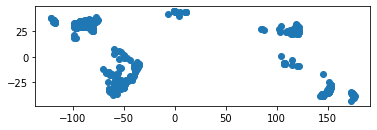

In [6]:
alty_gbif_subsamp=gpd.read_file('alty_gbif_subsamp.shp')
alty_gbif_subsamp.crs=from_epsg(4326)
alty_gbif_subsamp.plot()

In [7]:
import warnings 
warnings.filterwarnings(action='ignore')

In [8]:
ro.r('memory.limit(size=70000)')

array([1.7592186e+13])

In [9]:
def metric(matrix,y_test,p_cap):
    a=len(matrix[(matrix.observation==1)&(matrix.model==1)]) #present present
    b=len(matrix[(matrix.observation==0)&(matrix.model==1)]) #absent present
    c=len(matrix[(matrix.observation==1)&(matrix.model==0)]) #present absent
    d=len(matrix[(matrix.observation==0)&(matrix.model==0)]) #absent absent
    m=len(matrix)
    PCC=(a+d)/m
    Kappa=((a+d)-((a+c)*(a+b)+(b+d)*(c+d))/m)/(m-((a+c)*(a+b)+(b+d)*(c+d))/m)
    Sensitivity= a/(a+c)
    Specificity= d/(b+d)
    Precision= a/(a+b)
    NPP= d/(c+d)
    TSS= (a/(a+c))+(d/(b+d))-1
    FPR= b/(b+d)
    F_measure= (2*Precision*Sensitivity)/(Precision+Sensitivity)
    MCC= (a*d-b*c)/np.sqrt((a+b)*(a+c)*(b+d)*(c+d))
    auROC= metrics.roc_auc_score(y_test, p_cap)
    Fpr, tpr, thresholds = metrics.roc_curve(y_test, p_cap, pos_label=1)
    AUC=metrics.auc(Fpr,tpr)
    met=[a,b,c,d,PCC,Kappa,Sensitivity, Specificity, Precision, NPP, TSS, FPR, F_measure, MCC, auROC, AUC]
    return(met)
    

    

GAM regularization with SMOTE

In [10]:
#gamsel
accuracy_gamsel =[]; confusion_mat_gamsel =[]; evaluation_mat_gamsel =[]
pp =[]; pa =[]; ap =[]; aa =[]; pcc =[]; kappa =[]; sensitivity =[];
specificity =[]; precision =[]; npp =[]; tss =[]; fpr =[]
fmeasure =[]; mcc =[]; auroc =[]; auc =[]

for i in range(100):    
    geom_polygons=alty_mcp_polygons['geometry']
    geom_union=cascaded_union(geom_polygons)
    min_x1, min_y1, max_x1, max_y1=geom_union.bounds
    background_points=[]
    n=10000
    i=0
    while i < n:
        lons = np.random.uniform(min_x1, max_x1)
        lats = np.random.uniform(min_y1, max_y1)
        point = Point(lons,lats)
        if geom_union.contains(point):
            background_points.append(point)
            i += 1
    lon=[]
    lat=[]
    for i in range(n):
        lon.append(background_points[i].x)
        lat.append(background_points[i].y)
    data=pd.DataFrame({'lon':lon, 'lat': lat})
    len(data)
    pandas2ri.activate()
    occurrence_data=pd.DataFrame({'Species':np.repeat(1, len(alty_gbif_subsamp.species)),'lon': alty_gbif_subsamp.lon.values, 'lat': alty_gbif_subsamp.lat.values})
    background_data=pd.DataFrame({'Species':np.repeat(0, n), 'lon': lon, 'lat': lat})
    final_data=occurrence_data.append(background_data, sort=False)
    final_data = final_data.set_index([pd.Index(np.arange(0,len(final_data)))])
    geometry=[Point(xy) for xy in zip(final_data.lon, final_data.lat)]
    crs = CRS.from_epsg(4326)
    Species_data = gpd.GeoDataFrame(final_data, crs=crs, geometry = geometry)
    Species_data.to_file('Species_data.shp')
    Species_data = gpd.read_file('Species_data.shp')
    dir_soil = "C:/Users/admin/Desktop/Alternanthra philoxeroides/soilgrid0-30/"
    layer_0_5 = ["bdod_0-5cm_mean","cec_0-5cm_mean","cfvo_0-5cm_mean","clay_0-5cm_mean",
                 "nitrogen_0-5cm_mean","ocd_0-5cm_mean","phh2o_0-5cm_mean","silt_0-5cm_mean",
                 "soc_0-5cm_mean"]
    layer_5_15 = ["bdod_5-15cm_mean","cec_5-15cm_mean","cfvo_5-15cm_mean","clay_5-15cm_mean",
                 "nitrogen_5-15cm_mean","ocd_5-15cm_mean","phh2o_5-15cm_mean","silt_5-15cm_mean",
                 "soc_5-15cm_mean"]
    layers = [layer_0_5, layer_5_15]
    coords = [(x,y) for x,y in zip(Species_data.lon, Species_data.lat)]
    for j in range(len(layers)):
        for i in range(len(layers[j])):
            src = rasterio.open(dir_soil + layers[j][i] + ".tif")
            Species_data[layers[j][i]] = [x[0] for x in src.sample(coords)]
    Species_data.columns=['Species', 'lon', 'lat', 'geometry','SQ11','SQ12','SQ13','SQ14',
                  'SQ15','SQ16','SQ17','SQ18',
                  'SQ19','SQ21','SQ22','SQ23',
                  'SQ24','SQ25','SQ26','SQ27',
                  'SQ28','SQ29']
    Species_data.to_file('species_soil.shp', index=None)
    species_soil = gpd.read_file('species_soil.shp')
    shapefiles=importr('shapefiles')
    shapes=shapefiles.read_dbf("species_soil.dbf")
    data2=pd.DataFrame()
    data2['1']=np.repeat(1,len(species_soil.Species))
    data2[['lon','lat']]=species_soil[['lon','lat']]
    data2[['SQ11','SQ12','SQ13','SQ14',
                  'SQ15','SQ16','SQ17','SQ18',
                  'SQ19','SQ21','SQ22','SQ23',
                  'SQ24','SQ25','SQ26','SQ27',
                  'SQ28','SQ29']] = species_soil[['SQ11','SQ12','SQ13','SQ14','SQ15','SQ16','SQ17','SQ18',
                                                  'SQ19','SQ21','SQ22','SQ23','SQ24','SQ25','SQ26','SQ27','SQ28','SQ29']]
    data2['0']=np.repeat(0,len(species_soil.Species))
    sp=importr('sp')
    geodata=sp.SpatialPointsDataFrame(coords = data2[['lon','lat']], data = data2, proj4string = sp.CRS("+proj=longlat +datum=WGS84 +ellps=WGS84 +towgs84=0,0,0"))
    geodata
    raster=importr('raster')
    bioclim_data_=raster.getData(name="worldclim", download=True, var="bio", res=2.5, path="D:/Alien")
    #bioclim_data_=raster.getData(name="CMIP5", download=True, var="bio", res=2.5, rcp=26, model="GS", year=50, path="E:/r")

    bioclim_data=raster.extract(bioclim_data_, geodata, method="bilinear")
    bio=ro.pandas2ri.ri2py(bioclim_data)
    #name="worldclim", download=TRUE, var="bio", res=2.5, path="E:/r"
    bioclim=pd.DataFrame(bio, columns=['bio1','bio2','bio3','bio4','bio5','bio6','bio7','bio8','bio9','bio10','bio11','bio12','bio13','bio14','bio15','bio16','bio17','bio18','bio19'])
    bioclim.to_csv('bioclimgs_data.csv', index=None)
    bioclim=pd.read_csv('bioclimgs_data.csv')#bioclim['Species']=Species_data.Species.values
    bioclim[['Species', 'lon', 'lat', 'SQ11','SQ12','SQ13','SQ14',
              'SQ15','SQ16','SQ17','SQ18',
              'SQ19','SQ21','SQ22','SQ23',
              'SQ24','SQ25','SQ26','SQ27',
              'SQ28','SQ29']]=species_soil[['Species', 'lon', 'lat', 'SQ11','SQ12','SQ13','SQ14',
              'SQ15','SQ16','SQ17','SQ18',
              'SQ19','SQ21','SQ22','SQ23',
              'SQ24','SQ25','SQ26','SQ27',
              'SQ28','SQ29']]
    #bioclim=bioclim.drop(labels='Unnamed: 0', axis=1)
    bioclim.head()
    alty_clim=gpd.GeoDataFrame(bioclim, crs=species_soil.crs, geometry=species_soil.geometry)
    alty_clim=alty_clim[['Species', 'lon', 'lat', 'bio1', 'bio2', 'bio3', 'bio4', 'bio5', 'bio6', 'bio7', 'bio8', 'bio9',
           'bio10', 'bio11', 'bio12', 'bio13', 'bio14', 'bio15', 'bio16', 'bio17',
           'bio18', 'bio19', 'geometry','SQ11','SQ12','SQ13','SQ14',
                  'SQ15','SQ16','SQ17','SQ18',
                  'SQ19','SQ21','SQ22','SQ23',
                  'SQ24','SQ25','SQ26','SQ27',
                  'SQ28','SQ29']]
    alty_clim=alty_clim.dropna(axis=0)
    alty_clim.head()

    data=alty_clim
    data_n=data.drop(['lon','lat','geometry'], axis=1)
    X=data[['bio1', 'bio2', 'bio3', 'bio4', 'bio5', 'bio6', 'bio7', 'bio8', 'bio9', 'bio10', 
            'bio11', 'bio12', 'bio13', 'bio14', 'bio15', 'bio16', 'bio17','bio18', 'bio19',
            'SQ11','SQ12','SQ13','SQ14',
                  'SQ15','SQ16','SQ17','SQ18',
                  'SQ19','SQ21','SQ22','SQ23',
                  'SQ24','SQ25','SQ26','SQ27',
                  'SQ28','SQ29']]
    y=data[['Species']]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
    
    sm = SMOTE(random_state=42)
    X_train, y_train = sm.fit_resample(X_train, y_train)
    
    train_data=X_train; train_data['Species']=y_train;
    test_data=X_test; test_data['Species']=y_test;
    train_data.to_csv('traingm_data.csv',index=None, header=True)
    test_data.to_csv('testgm_data.csv',index=None, header=True)
    pandas2ri.deactivate()
    data=ro.r('data<-read.csv("traingm_data.csv")')
    lib_gamsel=ro.r('library(gamsel)')
    X=ro.r('X<-cbind(data$bio1, data$bio2, data$bio3, data$bio4, data$bio5, data$bio6, data$bio7, data$bio8, data$bio9, data$bio10, data$bio11, data$bio12, data$bio13, data$bio14, data$bio15, data$bio16, data$bio17, data$bio18, data$bio19, data$SQ11, data$SQ12, data$SQ13, data$SQ14, data$SQ15, data$SQ16, data$SQ17, data$SQ18, data$SQ19, data$SQ21, data$SQ22, data$SQ23, data$SQ24, data$SQ25, data$SQ26, data$SQ27, data$SQ28, data$SQ29)')
    Y=ro.r('Y<-c(data$Species)')

    bases=ro.r('bases<-pseudo.bases(X, degree =3, df =3, parallel=FALSE)')
    #gamsel=ro.r('gamsel.out<-gamsel(X, Y, num_lambda =50, lambda = NULL, family = "binomial", degrees = rep(10, p), gamma = 0.6, dfs = rep(5, p), bases = bases, tol = 1e-01, max_iter = 100, traceit = FALSE, parallel=FALSE)')
    gamsel = ro.r('gamsel.out<-cv.gamsel(X, Y, lambda=NULL, family="binomial", degree = rep(10, p), bases = bases, dfs = rep(10, p), type.measure = c("mse", "mae", "deviance", "class"), nfolds = 15)')


    test_data=ro.r('test<-read.csv("testgm_data.csv")')
    p_cap=ro.r('preds=predict(gamsel.out$gamsel.fit,test[-38],index=50,type="response")')
    
    
    accur=sum(y.values)/len(y.values)
    accuracy_gamsel.append(accur)
    model=np.zeros(len(X_test))
    for i in range(len(X_test)):
        if(p_cap[i]>=accur):
            model[i]=1
        else:
            model[i]=0
        #matrix= pd.DataFrame({'observation': data['Species'].values, 'predicted prob': p_cap[:,0], 'model': clf.predict(X)})
    matrix= pd.DataFrame({'observation': np.ravel(y_test.values), 'predicted prob': np.ravel(p_cap), 'model': model})
    [a,b,c,d,PCC,Kappa,Sensitivity,Specificity,Precision,NPP, TSS,FPR,F_measure,MCC,auROC,AUC]=metric(matrix,y_test,np.ravel(p_cap))
    pp.append(a); ap.append(b);pa.append(c);aa.append(d)
    #print(a,b,c,d)
    #condusion matrix
    conf_mat=pd.DataFrame({'predicted v /observed >': ['Present', 'Absent'], 'Present': [a,c], 'Absent':[b,d]})
    conf_mat.set_index('predicted v /observed >')
    confusion_mat_gamsel.append(conf_mat)
    pcc.append(PCC); kappa.append(Kappa); sensitivity.append(Sensitivity); specificity.append(Specificity); 
    precision.append(Precision); npp.append(NPP); tss.append(TSS); fpr.append(FPR); fmeasure.append(F_measure); mcc.append(MCC); 
    auroc.append(auROC); auc.append(AUC)
    #auROC is area under reciever operating curve
    modl_eval=[PCC, Kappa, Sensitivity, Specificity, Precision, NPP, TSS, FPR, F_measure, MCC, auROC, AUC]    
    modl_name=['PCC', 'Kappa', 'Sensitivity', 'Specificity', 'Precision(or PPP)', 'NPP', 'TSS', 'FPR', 'F measure', 'MCC', 'auROC', 'AUC']
    modl_expln=['Percent correctly identified', 'Difference between prediction accuracy and chance agreement', 'Proportion of observed presence correctly predicted', 'Proportion of observed absence correctly predicted', 'proportion of predicted presence correctly predicted', 'proportion of observed presence correctly predicted', 'True skill statistic', 'False positive rate(1 - Specificity)','','Matthews correlation coefficient', 'Area under receiver operating curve', 'Threshold Independent']
    #modl_eval=[r'$\frac{a+d}{n}=$', r'$\frac{(\(a+d\)-\frac{(\(a+c\)\(a+b\)+\(b+d\)\(c+d\))}{n})}{n-\frac{\(a+\c)\(a+\b)+\(b+d\)\(c+d\)}{n}}$', r'$\frac{a}{a+c}$',r'$\frac{3}{4} \binom{3}{4} \stackrel{3}{4}$', r'$\frac{3}{4} \binom{3}{4} \stackrel{3}{4}$', r'$\frac{3}{4} \binom{3}{4} \stackrel{3}{4}$', r'$\frac{3}{4} \binom{3}{4} \stackrel{3}{4}$', r'$\frac{3}{4} \binom{3}{4} \stackrel{3}{4}$', r'$\frac{3}{4} \binom{3}{4} \stackrel{3}{4}$', r'$\frac{3}{4} \binom{3}{4} \stackrel{3}{4}$', r'$\frac{3}{4} \binom{3}{4} \stackrel{3}{4}$', r'$\frac{3}{4} \binom{3}{4} \stackrel{3}{4}$']
    evalu=pd.DataFrame({'model name': modl_name, ' Explanation': modl_expln, 'Evaluation': modl_eval})
    evaluation_mat_gamsel.append(evalu)
    
#evaluation_mat_gamsel
gamsel_data=pd.DataFrame({'accuracy':accuracy_gamsel, 'present/present':pp, 'present/absent':pa, 'absent/present':ap,'absent/absent': aa, 'pcc':pcc,'kappa':kappa,'sensitivity':sensitivity,'specificity':specificity,'precision':precision,'npp':npp,'tss':tss,'fpr':fpr,'fmeasure':fmeasure,'mcc':mcc,'auroc':auroc,'auc':auc})
gamsel_data.to_csv('gamsels_data.csv')

GAM Regularization without SMOTE

In [11]:
#gamsel
accuracy_gamsel =[]; confusion_mat_gamsel =[]; evaluation_mat_gamsel =[]
pp =[]; pa =[]; ap =[]; aa =[]; pcc =[]; kappa =[]; sensitivity =[];
specificity =[]; precision =[]; npp =[]; tss =[]; fpr =[]
fmeasure =[]; mcc =[]; auroc =[]; auc =[]

for i in range(100):    
    geom_polygons=alty_mcp_polygons['geometry']
    geom_union=cascaded_union(geom_polygons)
    min_x1, min_y1, max_x1, max_y1=geom_union.bounds
    background_points=[]
    n=10000
    i=0
    while i < n:
        lons = np.random.uniform(min_x1, max_x1)
        lats = np.random.uniform(min_y1, max_y1)
        point = Point(lons,lats)
        if geom_union.contains(point):
            background_points.append(point)
            i += 1
    lon=[]
    lat=[]
    for i in range(n):
        lon.append(background_points[i].x)
        lat.append(background_points[i].y)
    data=pd.DataFrame({'lon':lon, 'lat': lat})
    len(data)
    pandas2ri.activate()
    occurrence_data=pd.DataFrame({'Species':np.repeat(1, len(alty_gbif_subsamp.species)),'lon': alty_gbif_subsamp.lon.values, 'lat': alty_gbif_subsamp.lat.values})
    background_data=pd.DataFrame({'Species':np.repeat(0, n), 'lon': lon, 'lat': lat})
    final_data=occurrence_data.append(background_data, sort=False)
    final_data = final_data.set_index([pd.Index(np.arange(0,len(final_data)))])
    geometry=[Point(xy) for xy in zip(final_data.lon, final_data.lat)]
    crs = CRS.from_epsg(4326)
    Species_data = gpd.GeoDataFrame(final_data, crs=crs, geometry = geometry)
    Species_data.to_file('Species_data.shp')
    Species_data = gpd.read_file('Species_data.shp')
    dir_soil = "C:/Users/admin/Desktop/Alternanthra philoxeroides/soilgrid0-30/"
    layer_0_5 = ["bdod_0-5cm_mean","cec_0-5cm_mean","cfvo_0-5cm_mean","clay_0-5cm_mean",
                 "nitrogen_0-5cm_mean","ocd_0-5cm_mean","phh2o_0-5cm_mean","silt_0-5cm_mean",
                 "soc_0-5cm_mean"]
    layer_5_15 = ["bdod_5-15cm_mean","cec_5-15cm_mean","cfvo_5-15cm_mean","clay_5-15cm_mean",
                 "nitrogen_5-15cm_mean","ocd_5-15cm_mean","phh2o_5-15cm_mean","silt_5-15cm_mean",
                 "soc_5-15cm_mean"]
    layers = [layer_0_5, layer_5_15]
    coords = [(x,y) for x,y in zip(Species_data.lon, Species_data.lat)]
    for j in range(len(layers)):
        for i in range(len(layers[j])):
            src = rasterio.open(dir_soil + layers[j][i] + ".tif")
            Species_data[layers[j][i]] = [x[0] for x in src.sample(coords)]
    Species_data.columns=['Species', 'lon', 'lat', 'geometry','SQ11','SQ12','SQ13','SQ14',
                  'SQ15','SQ16','SQ17','SQ18',
                  'SQ19','SQ21','SQ22','SQ23',
                  'SQ24','SQ25','SQ26','SQ27',
                  'SQ28','SQ29']
    Species_data.to_file('species_soil.shp', index=None)
    species_soil = gpd.read_file('species_soil.shp')
    shapefiles=importr('shapefiles')
    shapes=shapefiles.read_dbf("species_soil.dbf")
    data2=pd.DataFrame()
    data2['1']=np.repeat(1,len(species_soil.Species))
    data2[['lon','lat']]=species_soil[['lon','lat']]
    data2[['SQ11','SQ12','SQ13','SQ14',
                  'SQ15','SQ16','SQ17','SQ18',
                  'SQ19','SQ21','SQ22','SQ23',
                  'SQ24','SQ25','SQ26','SQ27',
                  'SQ28','SQ29']] = species_soil[['SQ11','SQ12','SQ13','SQ14','SQ15','SQ16','SQ17','SQ18',
                                                  'SQ19','SQ21','SQ22','SQ23','SQ24','SQ25','SQ26','SQ27','SQ28','SQ29']]
    data2['0']=np.repeat(0,len(species_soil.Species))
    sp=importr('sp')
    geodata=sp.SpatialPointsDataFrame(coords = data2[['lon','lat']], data = data2, proj4string = sp.CRS("+proj=longlat +datum=WGS84 +ellps=WGS84 +towgs84=0,0,0"))
    geodata
    raster=importr('raster')
    bioclim_data_=raster.getData(name="worldclim", download=True, var="bio", res=2.5, path="D:/Alien")
    #bioclim_data_=raster.getData(name="CMIP5", download=True, var="bio", res=2.5, rcp=26, model="GS", year=50, path="E:/r")

    bioclim_data=raster.extract(bioclim_data_, geodata, method="bilinear")
    bio=ro.pandas2ri.ri2py(bioclim_data)
    #name="worldclim", download=TRUE, var="bio", res=2.5, path="E:/r"
    bioclim=pd.DataFrame(bio, columns=['bio1','bio2','bio3','bio4','bio5','bio6','bio7','bio8','bio9','bio10','bio11','bio12','bio13','bio14','bio15','bio16','bio17','bio18','bio19'])
    bioclim.to_csv('bioclimgs_data.csv', index=None)
    bioclim=pd.read_csv('bioclimgs_data.csv')#bioclim['Species']=Species_data.Species.values
    bioclim[['Species', 'lon', 'lat', 'SQ11','SQ12','SQ13','SQ14',
              'SQ15','SQ16','SQ17','SQ18',
              'SQ19','SQ21','SQ22','SQ23',
              'SQ24','SQ25','SQ26','SQ27',
              'SQ28','SQ29']]=species_soil[['Species', 'lon', 'lat', 'SQ11','SQ12','SQ13','SQ14',
              'SQ15','SQ16','SQ17','SQ18',
              'SQ19','SQ21','SQ22','SQ23',
              'SQ24','SQ25','SQ26','SQ27',
              'SQ28','SQ29']]
    #bioclim=bioclim.drop(labels='Unnamed: 0', axis=1)
    bioclim.head()
    alty_clim=gpd.GeoDataFrame(bioclim, crs=species_soil.crs, geometry=species_soil.geometry)
    alty_clim=alty_clim[['Species', 'lon', 'lat', 'bio1', 'bio2', 'bio3', 'bio4', 'bio5', 'bio6', 'bio7', 'bio8', 'bio9',
           'bio10', 'bio11', 'bio12', 'bio13', 'bio14', 'bio15', 'bio16', 'bio17',
           'bio18', 'bio19', 'geometry','SQ11','SQ12','SQ13','SQ14',
                  'SQ15','SQ16','SQ17','SQ18',
                  'SQ19','SQ21','SQ22','SQ23',
                  'SQ24','SQ25','SQ26','SQ27',
                  'SQ28','SQ29']]
    alty_clim=alty_clim.dropna(axis=0)
    alty_clim.head()

    data=alty_clim
    data_n=data.drop(['lon','lat','geometry'], axis=1)
    X=data[['bio1', 'bio2', 'bio3', 'bio4', 'bio5', 'bio6', 'bio7', 'bio8', 'bio9', 'bio10', 
            'bio11', 'bio12', 'bio13', 'bio14', 'bio15', 'bio16', 'bio17','bio18', 'bio19',
            'SQ11','SQ12','SQ13','SQ14',
                  'SQ15','SQ16','SQ17','SQ18',
                  'SQ19','SQ21','SQ22','SQ23',
                  'SQ24','SQ25','SQ26','SQ27',
                  'SQ28','SQ29']]
    y=data[['Species']]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
    
    train_data=X_train; train_data['Species']=y_train;
    test_data=X_test; test_data['Species']=y_test;
    train_data.to_csv('traingm_data.csv',index=None, header=True)
    test_data.to_csv('testgm_data.csv',index=None, header=True)
    pandas2ri.deactivate()
    data=ro.r('data<-read.csv("traingm_data.csv")')
    lib_gamsel=ro.r('library(gamsel)')
    X=ro.r('X<-cbind(data$bio1, data$bio2, data$bio3, data$bio4, data$bio5, data$bio6, data$bio7, data$bio8, data$bio9, data$bio10, data$bio11, data$bio12, data$bio13, data$bio14, data$bio15, data$bio16, data$bio17, data$bio18, data$bio19, data$SQ11, data$SQ12, data$SQ13, data$SQ14, data$SQ15, data$SQ16, data$SQ17, data$SQ18, data$SQ19, data$SQ21, data$SQ22, data$SQ23, data$SQ24, data$SQ25, data$SQ26, data$SQ27, data$SQ28, data$SQ29)')
    Y=ro.r('Y<-c(data$Species)')

    bases=ro.r('bases<-pseudo.bases(X, degree =3, df =3, parallel=FALSE)')
    #gamsel=ro.r('gamsel.out<-gamsel(X, Y, num_lambda =50, lambda = NULL, family = "binomial", degrees = rep(10, p), gamma = 0.6, dfs = rep(5, p), bases = bases, tol = 1e-01, max_iter = 100, traceit = FALSE, parallel=FALSE)')
    gamsel = ro.r('gamsel.out<-cv.gamsel(X, Y, lambda=NULL, family="binomial", degree = rep(10, p), bases = bases, dfs = rep(10, p), type.measure = c("mse", "mae", "deviance", "class"), nfolds = 15)')


    test_data=ro.r('test<-read.csv("testgm_data.csv")')
    p_cap=ro.r('preds=predict(gamsel.out$gamsel.fit,test[-38],index=50,type="response")')
    
    
    accur=sum(y.values)/len(y.values)
    accuracy_gamsel.append(accur)
    model=np.zeros(len(X_test))
    for i in range(len(X_test)):
        if(p_cap[i]>=accur):
            model[i]=1
        else:
            model[i]=0
        #matrix= pd.DataFrame({'observation': data['Species'].values, 'predicted prob': p_cap[:,0], 'model': clf.predict(X)})
    matrix= pd.DataFrame({'observation': np.ravel(y_test.values), 'predicted prob': np.ravel(p_cap), 'model': model})
    [a,b,c,d,PCC,Kappa,Sensitivity,Specificity,Precision,NPP, TSS,FPR,F_measure,MCC,auROC,AUC]=metric(matrix,y_test,np.ravel(p_cap))
    pp.append(a); ap.append(b);pa.append(c);aa.append(d)
    #print(a,b,c,d)
    #condusion matrix
    conf_mat=pd.DataFrame({'predicted v /observed >': ['Present', 'Absent'], 'Present': [a,c], 'Absent':[b,d]})
    conf_mat.set_index('predicted v /observed >')
    confusion_mat_gamsel.append(conf_mat)
    pcc.append(PCC); kappa.append(Kappa); sensitivity.append(Sensitivity); specificity.append(Specificity); 
    precision.append(Precision); npp.append(NPP); tss.append(TSS); fpr.append(FPR); fmeasure.append(F_measure); mcc.append(MCC); 
    auroc.append(auROC); auc.append(AUC)
    #auROC is area under reciever operating curve
    modl_eval=[PCC, Kappa, Sensitivity, Specificity, Precision, NPP, TSS, FPR, F_measure, MCC, auROC, AUC]    
    modl_name=['PCC', 'Kappa', 'Sensitivity', 'Specificity', 'Precision(or PPP)', 'NPP', 'TSS', 'FPR', 'F measure', 'MCC', 'auROC', 'AUC']
    modl_expln=['Percent correctly identified', 'Difference between prediction accuracy and chance agreement', 'Proportion of observed presence correctly predicted', 'Proportion of observed absence correctly predicted', 'proportion of predicted presence correctly predicted', 'proportion of observed presence correctly predicted', 'True skill statistic', 'False positive rate(1 - Specificity)','','Matthews correlation coefficient', 'Area under receiver operating curve', 'Threshold Independent']
    #modl_eval=[r'$\frac{a+d}{n}=$', r'$\frac{(\(a+d\)-\frac{(\(a+c\)\(a+b\)+\(b+d\)\(c+d\))}{n})}{n-\frac{\(a+\c)\(a+\b)+\(b+d\)\(c+d\)}{n}}$', r'$\frac{a}{a+c}$',r'$\frac{3}{4} \binom{3}{4} \stackrel{3}{4}$', r'$\frac{3}{4} \binom{3}{4} \stackrel{3}{4}$', r'$\frac{3}{4} \binom{3}{4} \stackrel{3}{4}$', r'$\frac{3}{4} \binom{3}{4} \stackrel{3}{4}$', r'$\frac{3}{4} \binom{3}{4} \stackrel{3}{4}$', r'$\frac{3}{4} \binom{3}{4} \stackrel{3}{4}$', r'$\frac{3}{4} \binom{3}{4} \stackrel{3}{4}$', r'$\frac{3}{4} \binom{3}{4} \stackrel{3}{4}$', r'$\frac{3}{4} \binom{3}{4} \stackrel{3}{4}$']
    evalu=pd.DataFrame({'model name': modl_name, ' Explanation': modl_expln, 'Evaluation': modl_eval})
    evaluation_mat_gamsel.append(evalu)
    
#evaluation_mat_gamsel
gamsel_data=pd.DataFrame({'accuracy':accuracy_gamsel, 'present/present':pp, 'present/absent':pa, 'absent/present':ap,'absent/absent': aa, 'pcc':pcc,'kappa':kappa,'sensitivity':sensitivity,'specificity':specificity,'precision':precision,'npp':npp,'tss':tss,'fpr':fpr,'fmeasure':fmeasure,'mcc':mcc,'auroc':auroc,'auc':auc})
gamsel_data.to_csv('gamsel_data.csv')